In [4]:
!pip install pandas_datareader

In [8]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.2 MB/s eta 0:00:00a 0:00:01


In [10]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


In [12]:

# Set random seed for reproducibility
np.random.seed(42)

# 1. Data Sourcing from FRED
def fetch_fred_data(start_date='2000-01-01', end_date=datetime.today().strftime('%Y-%m-%d')):
    """Fetch Treasury yield data from FRED."""
    series = {
        'DGS3': '3_year_yield',
        'DGS5': '5_year_yield',
        'DGS7': '7_year_yield',
        'DGS10': '10_year_yield',
        'DGS20': '20_year_yield',
        'CPIAUCSL': 'cpi',  # Consumer Price Index
        'FEDFUNDS': 'fed_funds',  # Federal Funds Rate
        'VIXCLS': 'vix'  # VIX Index
    }
    df = pdr.get_data_fred(list(series.keys()), start_date, end_date)
    df = df.rename(columns=series)
    df = df.dropna()  # Drop rows with any missing values
    return df


In [14]:
# 2. Feature Engineering
def create_features(df, lags=5):
    """Generate lagged yields, term spreads, and rolling metrics."""
    df_features = df.copy()
    
    # Lagged yield values
    for col in ['3_year_yield', '5_year_yield', '7_year_yield', '10_year_yield', '20_year_yield']:
        for lag in range(1, lags + 1):
            df_features[f'{col}_lag{lag}'] = df_features[col].shift(lag)
    
    # Term spreads
    df_features['spread_10y_3y'] = df_features['10_year_yield'] - df_features['3_year_yield']
    df_features['spread_20y_10y'] = df_features['20_year_yield'] - df_features['10_year_yield']
    df_features['spread_20y_3y'] = df_features['20_year_yield'] - df_features['3_year_yield']
    
    # Rolling metrics (7-day and 30-day)
    for col in ['10_year_yield', 'spread_10y_3y']:
        df_features[f'{col}_ma7'] = df_features[col].rolling(window=7).mean()
        df_features[f'{col}_ma30'] = df_features[col].rolling(window=30).mean()
        df_features[f'{col}_vol7'] = df_features[col].rolling(window=7).std()
        df_features[f'{col}_vol30'] = df_features[col].rolling(window=30).std()
    
    # Drop rows with NaN values due to lagging/rolling
    df_features = df_features.dropna()
    return df_features

In [16]:

# 3. Prepare Data for Modeling
def prepare_data(df_features, target_col='10_year_yield'):
    """Split features and target, create train/test sets."""
    # Target: Next day's 10-year yield
    df_features['target'] = df_features[target_col].shift(-1)
    df_features = df_features.dropna()
    
    # Features: All columns except target and original macro inputs
    feature_cols = [col for col in df_features.columns if col not in ['target', 'cpi', 'fed_funds', 'vix']]
    X = df_features[feature_cols]
    y = df_features['target']
    
    return X, y

In [18]:
# 4. Model Training and Evaluation
def train_model(X, y, param_grid=None):
    """Train XGBRegressor with TimeSeriesSplit and hyperparameter tuning."""
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Default parameter grid if none provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    
    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search.fit(X, y)
    
    # Best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
    return best_model, grid_search


In [20]:

# 5. Model Evaluation
def evaluate_model(model, X, y):
    """Evaluate model performance with RMSE, MAE, and directional accuracy."""
    predictions = model.predict(X)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y, predictions))
    mae = mean_absolute_error(y, predictions)
    
    # Directional accuracy
    actual_diff = np.sign(y - y.shift(1).fillna(0))
    pred_diff = np.sign(pd.Series(predictions, index=y.index) - y.shift(1).fillna(0))
    directional_accuracy = np.mean(actual_diff == pred_diff) * 100
    
    # Print metrics
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(y.index, y, label='Actual 10Y Yield', color='blue')
    plt.plot(y.index, predictions, label='Predicted 10Y Yield', color='red', linestyle='--')
    plt.title('Actual vs Predicted 10-Year Treasury Yield')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig('yield_predictions.png')
    plt.close()
    
    # Feature importance plot
    feature_importance = model.get_booster().get_score(importance_type='gain')
    sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    plt.figure(figsize=(10, 6))
    plt.barh([x[0] for x in sorted_importance], [x[1] for x in sorted_importance])
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Gain')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    return {'rmse': rmse, 'mae': mae, 'directional_accuracy': directional_accuracy}

In [22]:
# 6. Forecasting Function
def forecast_next_day(model, df_features, latest_date):
    """Generate next-day forecast based on latest data."""
    latest_data = df_features.loc[latest_date].copy()
    feature_cols = [col for col in df_features.columns if col not in ['target', 'cpi', 'fed_funds', 'vix']]
    X_latest = latest_data[feature_cols].values.reshape(1, -1)
    forecast = model.predict(X_latest)[0]
    print(f"Forecasted 10Y Yield for {latest_date + timedelta(days=1)}: {forecast:.4f}%")
    return forecast

In [24]:
# Main Execution
if __name__ == "__main__":
    # Fetch data
    df = fetch_fred_data()
    
    # Create features
    df_features = create_features(df)
    
    # Prepare data
    X, y = prepare_data(df_features)
    
    # Train model
    model, grid_search = train_model(X, y)
    
    # Evaluate model
    metrics = evaluate_model(model, X, y)
    
    # Generate next-day forecast
    latest_date = df_features.index[-1]
    forecast = forecast_next_day(model, df_features, latest_date)
    
    # Save performance report
    with open('performance_report.txt', 'w') as f:
        f.write("10-Year Treasury Yield Forecast Performance Report\n")
        f.write(f"Date: {datetime.today().strftime('%Y-%m-%d')}\n\n")
        f.write(f"Best Parameters: {grid_search.best_params_}\n")
        f.write(f"RMSE: {metrics['rmse']:.4f}\n")
        f.write(f"MAE: {metrics['mae']:.4f}\n")
        f.write(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%\n")
        f.write(f"Forecast for {latest_date + timedelta(days=1)}: {forecast:.4f}%\n")
        f.write("\nPlots saved: yield_predictions.png, feature_importance.png")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
RMSE: 0.0010
MAE: 0.0008
Directional Accuracy: 98.18%
Forecasted 10Y Yield for 2025-04-02 00:00:00: 3.9150%


In [26]:
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime

# Define start and end dates for data retrieval
# It's good practice to make these configurable
start_date = datetime(2000, 1, 1) # Example start date
end_date = datetime.now() # Pull data up to the current date

# FRED Series IDs (confirm these on the FRED website)
fred_series = {
    'DGS3': '3Y_Treasury',
    'DGS5': '5Y_Treasury',
    'DGS7': '7Y_Treasury',
    'DGS10': '10Y_Treasury', # Target variable precursor
    'DGS20': '20Y_Treasury',
    'CPIAUCSL': 'CPI',
    'DFF': 'Fed_Funds',
    'VIXCLS': 'VIX'
}

# Fetch data
data_frames = {}
for series_id, column_name in fred_series.items():
    try:
        data_frames[column_name] = web.DataReader(series_id, 'fred', start_date, end_date)
        # Rename the column to something more descriptive immediately
        data_frames[column_name].rename(columns={series_id: column_name}, inplace=True)
        print(f"Successfully fetched {column_name}")
    except Exception as e:
        print(f"Could not fetch {series_id} ({column_name}): {e}")

# Combine into a single DataFrame
if data_frames:
    raw_data = pd.concat(data_frames.values(), axis=1)

    # Data Cleaning and Preprocessing
    # Convert all columns to numeric, coercing errors
    for col in raw_data.columns:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Handle missing values (e.g., forward fill, interpolate, or drop)
    # FRED data can have NaNs, especially for series that don't update daily
    # or on holidays.
    raw_data.ffill(inplace=True) # Forward fill is common for financial time series
    raw_data.bfill(inplace=True) # Backfill any remaining NaNs at the beginning

    print("\nRaw Data Head:")
    print(raw_data.head())
    print("\nRaw Data Info:")
    raw_data.info()
else:
    print("No data was fetched. Please check FRED series IDs and network connection.")

Successfully fetched 3Y_Treasury
Successfully fetched 5Y_Treasury
Successfully fetched 7Y_Treasury
Successfully fetched 10Y_Treasury
Successfully fetched 20Y_Treasury
Successfully fetched CPI
Successfully fetched Fed_Funds
Successfully fetched VIX

Raw Data Head:
            3Y_Treasury  5Y_Treasury  7Y_Treasury  10Y_Treasury  20Y_Treasury  \
DATE                                                                            
2000-01-01         6.42         6.50         6.65          6.58          6.94   
2000-01-02         6.42         6.50         6.65          6.58          6.94   
2000-01-03         6.42         6.50         6.65          6.58          6.94   
2000-01-04         6.34         6.40         6.56          6.49          6.84   
2000-01-05         6.43         6.51         6.68          6.62          6.95   

              CPI  Fed_Funds    VIX  
DATE                                 
2000-01-01  169.3       3.99  24.21  
2000-01-02  169.3       3.99  24.21  
2000-01-03  169.

In [28]:
# Assuming 'raw_data' DataFrame from previous step
# Define the target variable: next day's 10Y Treasury rate
# We need to shift the 10Y Treasury rate by -1 to get the next day's value as the target
if '10Y_Treasury' in raw_data.columns:
    raw_data['target'] = raw_data['10Y_Treasury'].shift(-1)
    # Drop the last row since it will have NaN for the target
    # raw_data.dropna(subset=['target'], inplace=True) # Do this after feature engineering that might use the last row
else:
    print("10Y_Treasury column not found. Cannot create target variable.")

In [30]:
features_df = raw_data.copy()
if 'target' in features_df.columns: # Ensure target is not lagged as a feature for itself directly
    cols_to_lag = [col for col in features_df.columns if col != 'target']
else:
    cols_to_lag = features_df.columns

lag_periods = 5
for col in cols_to_lag:
    if col in features_df: # Check if column exists (e.g. if CPI fetch failed)
        for lag in range(1, lag_periods + 1):
            features_df[f'{col}_lag_{lag}'] = features_df[col].shift(lag)

In [32]:
if all(col in features_df.columns for col in ['10Y_Treasury', '3Y_Treasury']):
    features_df['spread_10Y_3Y'] = features_df['10Y_Treasury'] - features_df['3Y_Treasury']
if all(col in features_df.columns for col in ['20Y_Treasury', '10Y_Treasury']):
    features_df['spread_20Y_10Y'] = features_df['20Y_Treasury'] - features_df['10Y_Treasury']
if all(col in features_df.columns for col in ['10Y_Treasury', '5Y_Treasury']):
    features_df['spread_10Y_5Y'] = features_df['10Y_Treasury'] - features_df['5Y_Treasury']
# Add more spreads as desired

In [34]:
rolling_windows = [5, 10, 20] # days
cols_for_rolling = ['10Y_Treasury', 'spread_10Y_3Y'] # Add more as needed, including other yields

for col in cols_for_rolling:
    if col in features_df:
        for window in rolling_windows:
            features_df[f'{col}_rolling_mean_{window}D'] = features_df[col].rolling(window=window).mean()
            features_df[f'{col}_rolling_std_{window}D'] = features_df[col].rolling(window=window).std()

In [36]:
# Drop rows with NaNs created by lagging and rolling features
# This also handles the NaN from the target variable shift for the last original row
final_df = features_df.dropna()

# Separate features (X) and target (y)
if 'target' in final_df.columns:
    X = final_df.drop(columns=['target'] + list(fred_series.values())) # Drop original raw series if only using engineered features, or keep them if desired
    # Or be more selective:
    # X = final_df.drop(columns=['target', '3Y_Treasury', '5Y_Treasury', ... , 'VIX']) # if original values are not to be used directly
    y = final_df['target']

    print("\nFeatures Head (X):")
    print(X.head())
    print("\nTarget Head (y):")
    print(y.head())
else:
    print("Target variable not found in final_df. Cannot proceed with model training.")


Features Head (X):
            3Y_Treasury_lag_1  3Y_Treasury_lag_2  3Y_Treasury_lag_3  \
DATE                                                                  
2000-01-20               6.51               6.53               6.49   
2000-01-21               6.55               6.51               6.53   
2000-01-22               6.54               6.55               6.51   
2000-01-23               6.54               6.54               6.55   
2000-01-24               6.54               6.54               6.54   

            3Y_Treasury_lag_4  3Y_Treasury_lag_5  5Y_Treasury_lag_1  \
DATE                                                                  
2000-01-20               6.49               6.49               6.62   
2000-01-21               6.49               6.49               6.67   
2000-01-22               6.53               6.49               6.67   
2000-01-23               6.51               6.53               6.67   
2000-01-24               6.55               6.51        

In [38]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV # or RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [40]:
n_splits = 5 # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

In [42]:
model = xgb.XGBRegressor(objective='reg:squarederror', # for regression
                         # Common starting parameters, tune these:
                         n_estimators=100,
                         learning_rate=0.1,
                         max_depth=3,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         random_state=42,
                         tree_method='hist' # Efficient for large datasets
                        )

In [44]:
# Define parameter grid for GridSearchCV
# This is a small example, expand it for a real search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.7, 0.8, 0.9]
}

if 'X' in locals() and 'y' in locals(): # Check if X and y are defined
    print("\nStarting Hyperparameter Tuning...")
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_root_mean_squared_error', # Lower is better
                               cv=tscv,
                               verbose=1,
                               n_jobs=-1) # Use all available cores

    grid_search.fit(X, y)

    print("\nBest Parameters Found:")
    print(grid_search.best_params_)

    best_model = grid_search.best_estimator_
else:
    print("X and/or y are not defined. Skipping model training and tuning.")


Starting Hyperparameter Tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters Found:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [46]:
# For a proper train-test split before CV for final evaluation:
if 'X' in locals() and 'y' in locals():
    train_size = int(len(X) * 0.8) # Example: 80% for training (including CV), 20% for final hold-out test
    X_train_cv, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train_cv, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Then run GridSearchCV or Optuna on X_train_cv, y_train_cv
    # grid_search.fit(X_train_cv, y_train_cv)
    # best_model = grid_search.best_estimator_

    # Or, if you used Optuna:
    # study.optimize(lambda trial: objective(trial, X_train_cv, y_train_cv), n_trials=50)
    # best_model = xgb.XGBRegressor(**study.best_trial.params, objective='reg:squarederror', random_state=42)
    # best_model.fit(X_train_cv, y_train_cv) # Refit on the full training portion

    # If you didn't do a separate train/test split earlier and used all X, y for grid_search:
    # best_model is already trained. You'd ideally want a hold-out set.
    # For now, let's assume best_model is ready from grid_search on the full X, y.
    # Predictions will be made on the validation folds, or on X itself for an "in-sample" view for now.
    # To get out-of-sample predictions for evaluation, we need a dedicated test set.
    # Let's proceed assuming `best_model` is trained and `X_test`, `y_test` are available from a split.
    # If no explicit split was made, use the last fold of TSCV as a pseudo-test set or predict on X.

    # If X_test and y_test were defined:
    if 'X_test' in locals() and 'y_test' in locals() and best_model is not None:
        test_predictions = best_model.predict(X_test)
        print("\nTest Set Predictions (first 5):")
        print(test_predictions[:5])
    elif best_model is not None: # If no X_test, just illustrate predicting on last part of X
        print("No dedicated test set X_test found. Showing predictions on last part of training data X as example.")
        example_predictions = best_model.predict(X.tail()) # Example
        print("\nExample Predictions (on X.tail()):")
        print(example_predictions)
else:
    print("Cannot make predictions as model or data is not ready.")


Test Set Predictions (first 5):
[0.6601972  0.64946103 0.631798   0.6585625  0.6429834 ]


In [50]:
if 'test_predictions' in locals() and 'y_test' in locals():
    rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mae = mean_absolute_error(y_test, test_predictions)

    print(f"\nTest Set RMSE: {rmse:.4f}")
    print(f"Test Set MAE: {mae:.4f}")

    # Directional Accuracy
    # Actual daily change for the test set
    actual_change = y_test - X_test['10Y_Treasury_lag_1'] # y_test is T+1 rate, X_test['10Y_Treasury_lag_1'] is T rate
    # Predicted daily change
    # The prediction 'test_predictions' is the predicted rate for T+1.
    # So, predicted_change = predicted_rate_T+1 - actual_rate_T
    predicted_change = test_predictions - X_test['10Y_Treasury_lag_1']

    # Correct if signs match (or both are zero)
    correct_direction = (np.sign(actual_change) == np.sign(predicted_change)) | ((actual_change == 0) & (predicted_change == 0))
    directional_accuracy = np.mean(correct_direction) * 100
    print(f"Test Set Directional Accuracy: {directional_accuracy:.2f}%")

elif 'example_predictions' in locals() and 'y' in locals() and best_model is not None: # Fallback for illustration
    y_example_true = y.tail()
    # Assuming '10Y_Treasury_lag_1' is available and aligned with X.tail()
    if '10Y_Treasury_lag_1' in X.columns:
        actual_change_example = y_example_true - X.tail()['10Y_Treasury_lag_1']
        predicted_change_example = example_predictions - X.tail()['10Y_Treasury_lag_1']
        correct_direction_example = (np.sign(actual_change_example) == np.sign(predicted_change_example)) | ((actual_change_example == 0) & (predicted_change_example == 0))
        directional_accuracy_example = np.mean(correct_direction_example) * 100
        print(f"Example Directional Accuracy (on X.tail()): {directional_accuracy_example:.2f}%")
    else:
        print("Cannot calculate directional accuracy for example, '10Y_Treasury_lag_1' missing from X.tail() context.")
else:
    print("Cannot calculate metrics: Predictions or true values are missing.")


Test Set RMSE: 0.0657
Test Set MAE: 0.0486
Test Set Directional Accuracy: 50.35%


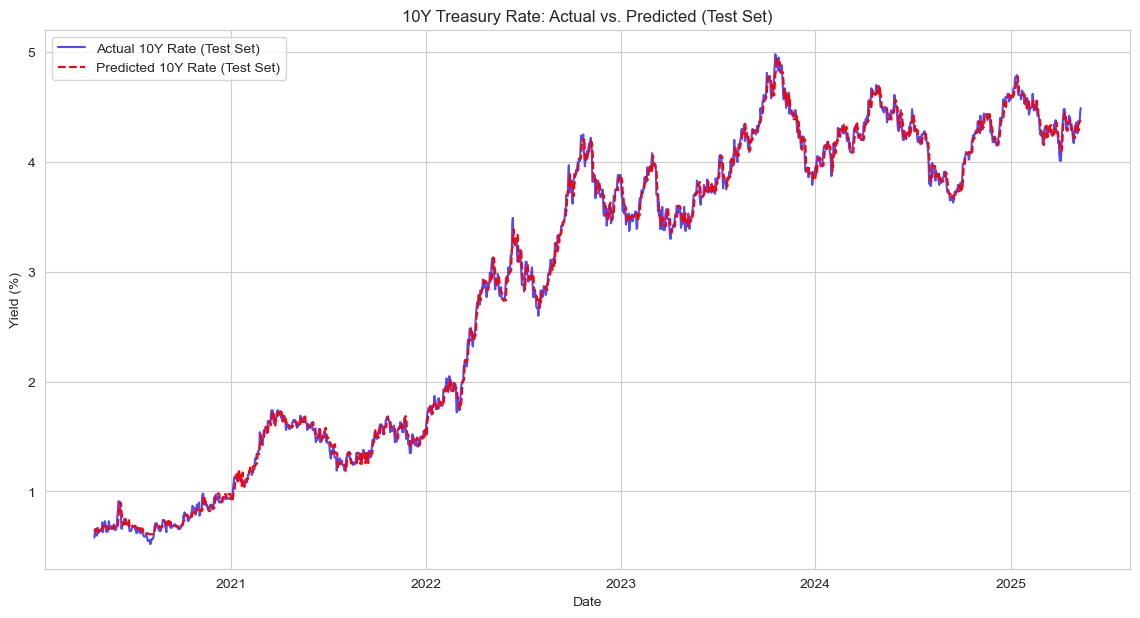

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

if 'test_predictions' in locals() and 'y_test' in locals():
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual 10Y Rate (Test Set)', color='blue', alpha=0.7)
    plt.plot(y_test.index, test_predictions, label='Predicted 10Y Rate (Test Set)', color='red', linestyle='--')
    plt.title('10Y Treasury Rate: Actual vs. Predicted (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.show()
elif 'example_predictions' in locals() and 'y' in locals(): # Fallback for illustration
    plt.figure(figsize=(14, 7))
    plt.plot(y.tail().index, y.tail(), label='Actual 10Y Rate (Example)', color='blue', alpha=0.7)
    plt.plot(y.tail().index, example_predictions, label='Predicted 10Y Rate (Example)', color='red', linestyle='--')
    plt.title('10Y Treasury Rate: Actual vs. Predicted (Example on X.tail())')
    plt.xlabel('Date')
    plt.ylabel('Yield (%)')
    plt.legend()
    plt.show()
else:
    print("Cannot generate plot: Predictions or true values are missing.")

<Figure size 1200x800 with 0 Axes>

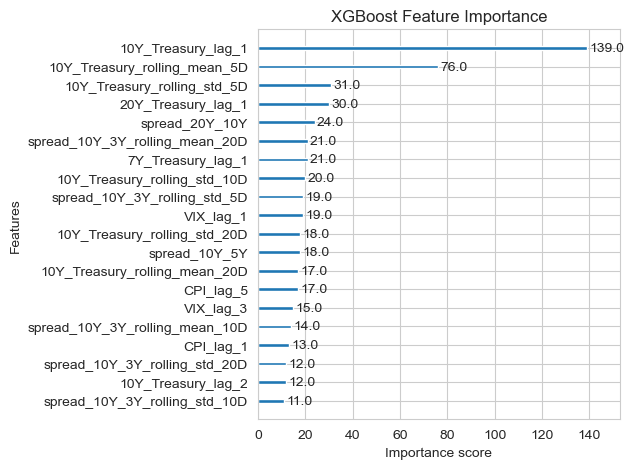


Feature Importances:
                           feature  importance
15              10Y_Treasury_lag_1       139.0
41    10Y_Treasury_rolling_mean_5D        76.0
42     10Y_Treasury_rolling_std_5D        31.0
20              20Y_Treasury_lag_1        30.0
39                  spread_20Y_10Y        24.0
51  spread_10Y_3Y_rolling_mean_20D        21.0
10               7Y_Treasury_lag_1        21.0
44    10Y_Treasury_rolling_std_10D        20.0
33                       VIX_lag_1        19.0
48    spread_10Y_3Y_rolling_std_5D        19.0
40                   spread_10Y_5Y        18.0
46    10Y_Treasury_rolling_std_20D        18.0
28                       CPI_lag_5        17.0
45   10Y_Treasury_rolling_mean_20D        17.0
35                       VIX_lag_3        15.0
49  spread_10Y_3Y_rolling_mean_10D        14.0
24                       CPI_lag_1        13.0
16              10Y_Treasury_lag_2        12.0
52   spread_10Y_3Y_rolling_std_20D        12.0
50   spread_10Y_3Y_rolling_std_10D    

In [54]:
if 'best_model' in locals() and best_model is not None and 'X' in locals():
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(best_model, max_num_features=20) # Show top 20 features
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

    # Alternatively, get importances as a dictionary/DataFrame
    importances = best_model.get_booster().get_score(importance_type='weight') # or 'gain', 'cover'
    importance_df = pd.DataFrame(importances.items(), columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
    print("\nFeature Importances:")
    print(importance_df.head(20))
else:
    print("Cannot generate feature importance: Model or features are missing.")

In [56]:
# --- main_forecasting_script.py ---
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import xgboost as xgb
from datetime import datetime, timedelta
import joblib # For saving/loading model

# --- 1. Configuration & Global Variables ---
FRED_SERIES = {
    'DGS3': '3Y_Treasury', 'DGS5': '5Y_Treasury', 'DGS7': '7Y_Treasury',
    'DGS10': '10Y_Treasury', 'DGS20': '20Y_Treasury', 'CPIAUCSL': 'CPI',
    'DFF': 'Fed_Funds', 'VIXCLS': 'VIX'
}
MODEL_FILENAME = 'xgb_10y_treasury_model.joblib'
LAG_PERIODS = 5
ROLLING_WINDOWS = [5, 10, 20]
# List of features the model was trained on (important for consistency)
# This should be saved after training, or derived consistently
# For example: X_train_cv.columns.tolist()
# Let's assume it's stored in a file or hardcoded for simplicity here
# FEATURE_COLUMNS = ['feature1', 'feature2', ...] # Load this from training

# --- 2. Data Fetching Function ---
def fetch_latest_data(series_dict, days_to_fetch=90):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_to_fetch) # Fetch enough data for lags and rolling features
    data_frames = {}
    for series_id, col_name in series_dict.items():
        try:
            df = web.DataReader(series_id, 'fred', start_date, end_date)
            df.rename(columns={series_id: col_name}, inplace=True)
            data_frames[col_name] = df
        except Exception as e:
            print(f"Warning: Could not fetch {series_id} ({col_name}): {e}")
    if not data_frames:
        raise ValueError("No data could be fetched from FRED.")

    raw_data = pd.concat(data_frames.values(), axis=1)
    for col in raw_data.columns:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')
    raw_data.ffill(inplace=True)
    raw_data.bfill(inplace=True) # Backfill for safety, though ideally recent data is present
    return raw_data

# --- 3. Feature Engineering Function ---
def engineer_features(df, lag_periods, rolling_windows, fred_series_cols):
    features_df = df.copy()
    # Lagged Yield Values (and other series)
    cols_to_lag = fred_series_cols # Lag all fetched series
    for col in cols_to_lag:
        if col in features_df:
            for lag in range(1, lag_periods + 1):
                features_df[f'{col}_lag_{lag}'] = features_df[col].shift(lag)

    # Term Spreads (ensure base columns exist)
    if '10Y_Treasury' in features_df and '3Y_Treasury' in features_df:
        features_df['spread_10Y_3Y'] = features_df['10Y_Treasury'] - features_df['3Y_Treasury']
    if '20Y_Treasury' in features_df and '10Y_Treasury' in features_df:
        features_df['spread_20Y_10Y'] = features_df['20Y_Treasury'] - features_df['10Y_Treasury']
    if '10Y_Treasury' in features_df and '5Y_Treasury' in features_df:
        features_df['spread_10Y_5Y'] = features_df['10Y_Treasury'] - features_df['5Y_Treasury']


    # Rolling Metrics
    cols_for_rolling = [col for col in ['10Y_Treasury', 'spread_10Y_3Y'] if col in features_df]
    for col in cols_for_rolling:
        for window in rolling_windows:
            features_df[f'{col}_rolling_mean_{window}D'] = features_df[col].rolling(window=window).mean()
            features_df[f'{col}_rolling_std_{window}D'] = features_df[col].rolling(window=window).std()

    # Return only the last row needed for prediction, which should now have all features
    return features_df.tail(1) # We only need the latest features for next-day prediction

# --- 4. Prediction Function ---
def make_prediction(model, feature_df_row, feature_columns_ordered):
    # Ensure columns are in the same order as during training
    # And only expected columns are present
    try:
        # If feature_columns_ordered was derived from X.columns during training
        # Ensure all those columns exist in feature_df_row
        missing_cols = set(feature_columns_ordered) - set(feature_df_row.columns)
        if missing_cols:
            raise ValueError(f"Missing columns in input for prediction: {missing_cols}")

        prediction_input = feature_df_row[feature_columns_ordered]

        # Check for NaNs in the input row
        if prediction_input.isnull().values.any():
            raise ValueError(f"NaN values found in prediction input row: \n{prediction_input[prediction_input.isnull().any(axis=1)]}")

        prediction = model.predict(prediction_input)
        return prediction[0]
    except Exception as e:
        print(f"Error during prediction: {e}")
        print("Prediction input:")
        print(prediction_input)
        return None


# --- Main Execution Block for Scheduled Task ---
if __name__ == '__main__':
    print(f"Forecasting script started at {datetime.now()}")
    try:
        # Step 1: Load the trained model
        print(f"Loading model from {MODEL_FILENAME}...")
        # Ensure the model file exists (it should be saved after the training script runs)
        # For this example, let's assume 'best_model' from the training phase is saved.
        # joblib.dump(best_model, MODEL_FILENAME) # This would be in your training script
        # FEATURE_COLUMNS = X.columns.tolist() # Also save this from training
        # joblib.dump(FEATURE_COLUMNS, 'feature_columns.joblib')

        model = joblib.load(MODEL_FILENAME)
        try:
            FEATURE_COLUMNS = joblib.load('feature_columns.joblib') # Load the feature column order
        except FileNotFoundError:
            print("Error: feature_columns.joblib not found. This file should contain the list of feature names used during training.")
            exit()


        # Step 2: Fetch the latest data
        print("Fetching latest data from FRED...")
        # Need enough historical data to compute all lags and rolling features for the *latest* day
        # e.g., if max lag is 5 and max rolling window is 20, need at least 25 business days ~ 35 calendar days.
        # Let's fetch more to be safe (e.g., 90 calendar days)
        latest_raw_data = fetch_latest_data(FRED_SERIES, days_to_fetch=90)
        if latest_raw_data.empty:
            print("Failed to fetch sufficient recent data. Exiting.")
            exit()

        # Step 3: Engineer features for the latest data point
        print("Engineering features for the latest data...")
        # The fred_series.values() gives the column names in the raw_data df
        latest_features_row = engineer_features(latest_raw_data, LAG_PERIODS, ROLLING_WINDOWS, list(FRED_SERIES.values()))

        if latest_features_row.empty:
            print("Failed to engineer features for the latest data. Exiting.")
            exit()

        # Ensure the latest_features_row has all necessary columns after engineering.
        # This might involve selecting only the columns that were used for training.

        # Step 4: Make prediction
        print("Making next-day prediction...")
        next_day_10y_rate_prediction = make_prediction(model, latest_features_row, FEATURE_COLUMNS)

        if next_day_10y_rate_prediction is not None:
            current_10y_rate = latest_raw_data['10Y_Treasury'].iloc[-1]
            predicted_movement = next_day_10y_rate_prediction - current_10y_rate

            print(f"\n--- Forecast for Next Trading Day ---")
            print(f"Current 10Y Treasury Rate ({latest_raw_data.index[-1].strftime('%Y-%m-%d')}): {current_10y_rate:.3f}%")
            print(f"Predicted Next Day 10Y Treasury Rate: {next_day_10y_rate_prediction:.3f}%")
            print(f"Predicted Movement: {predicted_movement:+.3f}%")
        else:
            print("Prediction failed.")

    except FileNotFoundError:
        print(f"Error: Model file '{MODEL_FILENAME}' not found. Please train and save the model first.")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

    print(f"\nForecasting script finished at {datetime.now()}")

# To complete the deployment part:
# 1. Save your trained `best_model` and `X.columns.tolist()` after the training phase:
#    `import joblib`
#    `joblib.dump(best_model, 'xgb_10y_treasury_model.joblib')`
#    `joblib.dump(X.columns.tolist(), 'feature_columns.joblib')`
#
# 2. Schedule `main_forecasting_script.py` using cron (Linux/macOS) or Task Scheduler (Windows).

Forecasting script started at 2025-05-15 11:01:01.710491
Loading model from xgb_10y_treasury_model.joblib...
Error: Model file 'xgb_10y_treasury_model.joblib' not found. Please train and save the model first.

Forecasting script finished at 2025-05-15 11:01:01.710975


In [4]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# ── CONFIG ────────────────────────────────────────────────────────────────
FRED_SERIES = {
    'DGS3': '3Y_Treasury', 'DGS5': '5Y_Treasury',
    'DGS7': '7Y_Treasury','DGS10': '10Y_Treasury',
    'DGS20': '20Y_Treasury','CPIAUCSL': 'CPI',
    'DFF': 'Fed_Funds','VIXCLS': 'VIX'
}
LAG_PERIODS    = 5
ROLLING_WINDOWS = [5, 10, 20]
MODEL_FILENAME           = 'xgb_10y_treasury_model.joblib'
FEATURE_COLUMNS_FILENAME = 'feature_columns.joblib'


def fetch_data(days=2000):
    end = datetime.now()
    start = end - timedelta(days=days)
    dfs = []
    for sid, name in FRED_SERIES.items():
        df = web.DataReader(sid, 'fred', start, end).rename(columns={sid: name})
        dfs.append(df)
    data = pd.concat(dfs, axis=1).apply(pd.to_numeric, errors='coerce')
    data.ffill(inplace=True); data.bfill(inplace=True)
    return data

def make_features(df):
    df = df.copy()
    # 1) lags
    for col in FRED_SERIES.values():
        for lag in range(1, LAG_PERIODS+1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # 2) spreads
    df['spread_10Y_3Y']  = df['10Y_Treasury'] - df['3Y_Treasury']
    df['spread_20Y_10Y'] = df['20Y_Treasury'] - df['10Y_Treasury']
    df['spread_10Y_5Y']  = df['10Y_Treasury'] - df['5Y_Treasury']

    # 3) rolling stats
    for col in ['10Y_Treasury','spread_10Y_3Y']:
        for w in ROLLING_WINDOWS:
            df[f'{col}_rolling_mean_{w}D'] = df[col].rolling(w).mean()
            df[f'{col}_rolling_std_{w}D']  = df[col].rolling(w).std()

    return df

if __name__ == '__main__':
    # Fetch & engineer
    raw = fetch_data()
    feats = make_features(raw)

    # Align target: next-day 10Y rate
    feats['target'] = feats['10Y_Treasury'].shift(-1)
    df = feats.dropna()

    X = df.drop(columns= list(FRED_SERIES.values()) + ['target'])
    y = df['target']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Train a simple XGB regressor
    model = xgb.XGBRegressor(
        n_estimators=200, max_depth=5,
        learning_rate=0.1, subsample=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Evaluate
    yp = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, yp))
    mae  = mean_absolute_error(y_test, yp)
    print(f"Test RMSE: {rmse:.4f}  MAE: {mae:.4f}")

    # Save
    joblib.dump(model, MODEL_FILENAME)
    joblib.dump(X.columns.tolist(), FEATURE_COLUMNS_FILENAME)
    print(f"Saved model → {MODEL_FILENAME}")
    print(f"Saved feature list → {FEATURE_COLUMNS_FILENAME}")


Test RMSE: 0.1260  MAE: 0.0967
Saved model → xgb_10y_treasury_model.joblib
Saved feature list → feature_columns.joblib


In [10]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import joblib, os, traceback
from datetime import datetime, timedelta

# ── CONFIG ────────────────────────────────────────────────────────────────
FRED_SERIES = {
    'DGS3': '3Y_Treasury','DGS5': '5Y_Treasury',
    'DGS7': '7Y_Treasury','DGS10': '10Y_Treasury',
    'DGS20': '20Y_Treasury','CPIAUCSL': 'CPI',
    'DFF': 'Fed_Funds','VIXCLS': 'VIX'
}
MODEL_FILENAME           = 'xgb_10y_treasury_model.joblib'
FEATURE_COLUMNS_FILENAME = 'feature_columns.joblib'
LAG_PERIODS    = 5
ROLLING_WINDOWS = [5, 10, 20]

def fetch_latest(days=90):
    end = datetime.now()
    start = end - timedelta(days=days)
    dfs = []
    for sid, name in FRED_SERIES.items():
        try:
            df = web.DataReader(sid, 'fred', start, end).rename(columns={sid: name})
            dfs.append(df)
        except Exception as e:
            print(f"Warning: {sid} → {e}")
    raw = pd.concat(dfs, axis=1).apply(pd.to_numeric, errors='coerce')
    raw.ffill(inplace=True); raw.bfill(inplace=True)
    return raw

def engineer(df):
    df = df.copy()
    for col in FRED_SERIES.values():
        for lag in range(1, LAG_PERIODS+1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df['spread_10Y_3Y']  = df['10Y_Treasury'] - df['3Y_Treasury']
    df['spread_20Y_10Y'] = df['20Y_Treasury'] - df['10Y_Treasury']
    df['spread_10Y_5Y']  = df['10Y_Treasury'] - df['5Y_Treasury']
    for col in ['10Y_Treasury','spread_10Y_3Y']:
        for w in ROLLING_WINDOWS:
            df[f'{col}_rolling_mean_{w}D'] = df[col].rolling(w).mean()
            df[f'{col}_rolling_std_{w}D']  = df[col].rolling(w).std()
    return df.tail(1)

def make_prediction(model, row, cols):
    miss = set(cols) - set(row.columns)
    if miss:
        raise ValueError(f"Missing cols: {miss}")
    X = row[cols]
    if X.isnull().any().any():
        raise ValueError("NaNs in input!")
    return model.predict(X)[0]

if __name__ == '__main__':
    print(f"Started at {datetime.now()}")
    try:
        # 1) check files
        if not os.path.exists(MODEL_FILENAME) or not os.path.exists(FEATURE_COLUMNS_FILENAME):
            print("Error: model or feature list missing. Run training script first.")
            exit()

        print("Loading model...")
        model = joblib.load(MODEL_FILENAME)
        FEATURE_COLUMNS = joblib.load(FEATURE_COLUMNS_FILENAME)

        # 2) data
        raw = fetch_latest(90)
        feats = engineer(raw)

        # 3) predict
        pred = make_prediction(model, feats, FEATURE_COLUMNS)
        current = raw['10Y_Treasury'].iloc[-1]
        move    = pred - current

        print("\n--- Next-Day 10Y Treasury Forecast ---")
        print(f"Date: {raw.index[-1].strftime('%Y-%m-%d')}")
        print(f"Current: {current:.3f}%")
        print(f"Predicted: {pred:.3f}%  ({move:+.3f}%)")

    except Exception as e:
        print("Forecasting error:")
        traceback.print_exc()
    finally:
        print(f"\nFinished at {datetime.now()}")


Started at 2025-05-15 11:07:09.355199
Loading model...

--- Next-Day 10Y Treasury Forecast ---
Date: 2025-05-13
Current: 4.490%
Predicted: 4.362%  (-0.128%)

Finished at 2025-05-15 11:07:11.470643
